Idealised 2-D multi-material mantle convection problem inside an annulus
=

This example
-

In this tutorial, we analyse mantle flow in a 2-D annulus domain where a denser and
more viscous layer, which could represent some lower-mantle structures on Earth, is
initially defined in the lower third of the domain.

This example highlights the effect of the denser and more viscous layer on the
dynamics already presented in a
[previous tutorial](../../mantle_convection/2d_cylindrical). To make the comparison
meaningful, we use the exact same setup apart from the distinct compositional layer.
The reader is encouraged to first review the single-material tutorial before exploring
the present multi-material one.

The first step is to import the `gadopt` module, which provides access to Firedrake
and associated functionality. We also import `pyvista` for plotting purposes.

In [1]:
from gadopt import *

In [2]:
import pyvista as pv

We next set up the mesh and function spaces and define functions to hold our solutions
and the simulation's time step.

In [3]:
# Annulus radii (e.g. [van Keken (2001)](https://doi.org/10.1016/S0031-9201(01)00195-9))
rmin, rmax = 1.2083, 2.2083
mesh1d = CircleManifoldMesh(ncells=128, radius=rmin, degree=2)  # Circle mesh
mesh = ExtrudedMesh(mesh1d, layers=32, extrusion_type="radial")  # Annulus mesh
mesh.cartesian = False
boundary = get_boundary_ids(mesh)

V = VectorFunctionSpace(mesh, "Q", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "Q", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "Q", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space
K = FunctionSpace(mesh, "DQ", 2)  # Level-set function space (scalar, discontinuous)
R = FunctionSpace(mesh, "R", 0)  # Real space (constants across the domain)

stokes = Function(Z)  # A field over the mixed function space Z
stokes.subfunctions[0].rename("Velocity")  # Firedrake function for velocity
stokes.subfunctions[1].rename("Pressure")  # Firedrake function for pressure
u = split(stokes)[0]  # Indexed expression for velocity in the mixed space
T = Function(Q, name="Temperature")  # Firedrake function for temperature
psi = Function(K, name="Level set")  # Firedrake function for level set
time_step = Function(R).assign(1e-7)  # Initial time step

We can now visualise the resulting mesh.

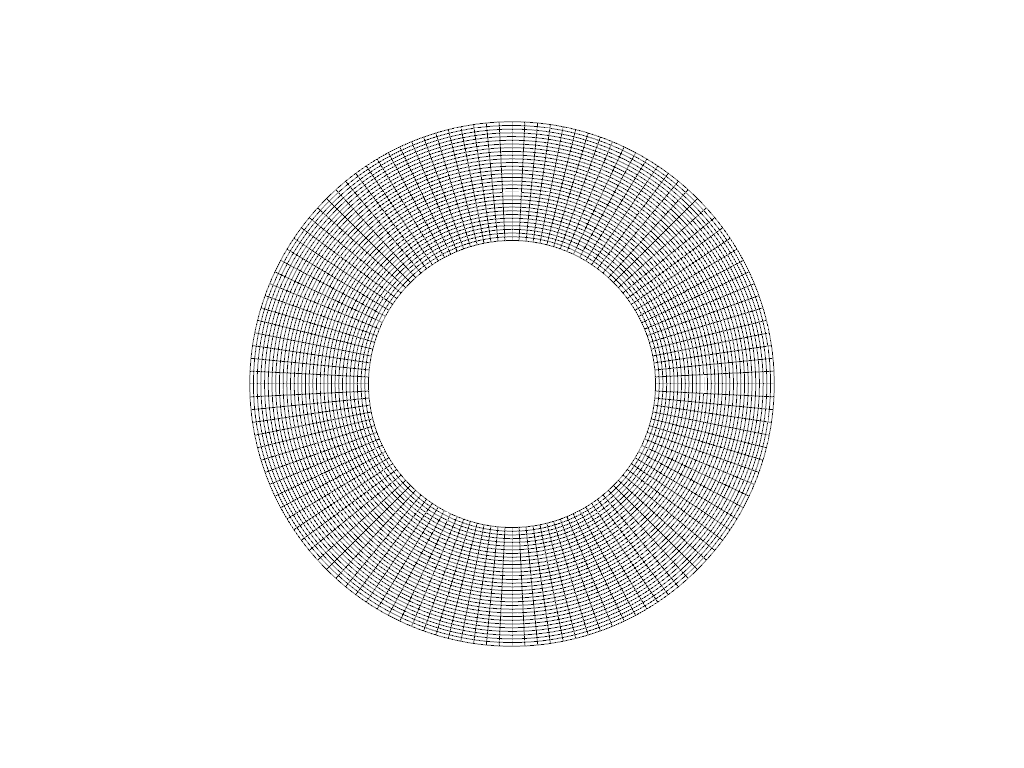

In [4]:
VTKFile("mesh.pvd").write(Function(V))
mesh_data = pv.read("mesh/mesh_0.vtu")
edges = mesh_data.extract_all_edges()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(edges, color="black")
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

We next initialise our temperature field. We choose a spatial distribution that will
enable the upwelling of four equidistant plumes, using the following equation:

$T(x, y) = r_{\text{max}} - r + A\cos\left(4 \arctan\left(\frac{y}{x}\right)\right)  \sin((r - r_{\text{min}}) \pi)$

where $A = 0.02$ is the amplitude of the initial perturbation.

In [5]:
x, y = SpatialCoordinate(mesh)  # UFL representation of spatial coordinates
r = sqrt(x**2 + y**2)  # Radial coordinate
T.interpolate(rmax - r + 0.02 * cos(4.0 * atan2(y, x)) * sin((r - rmin) * pi))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.ExtrudedMeshTopology object at 0x73608d129670>, TensorProductElement(FiniteElement('Lagrange', interval, 2), FiniteElement('Lagrange', interval, 2), cell=TensorProductCell(interval, interval)), name=None), Mesh(VectorElement(TensorProductElement(FiniteElement('Lagrange', interval, 2), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), dim=2), 6)), 19)

We can plot this initial temperature field:

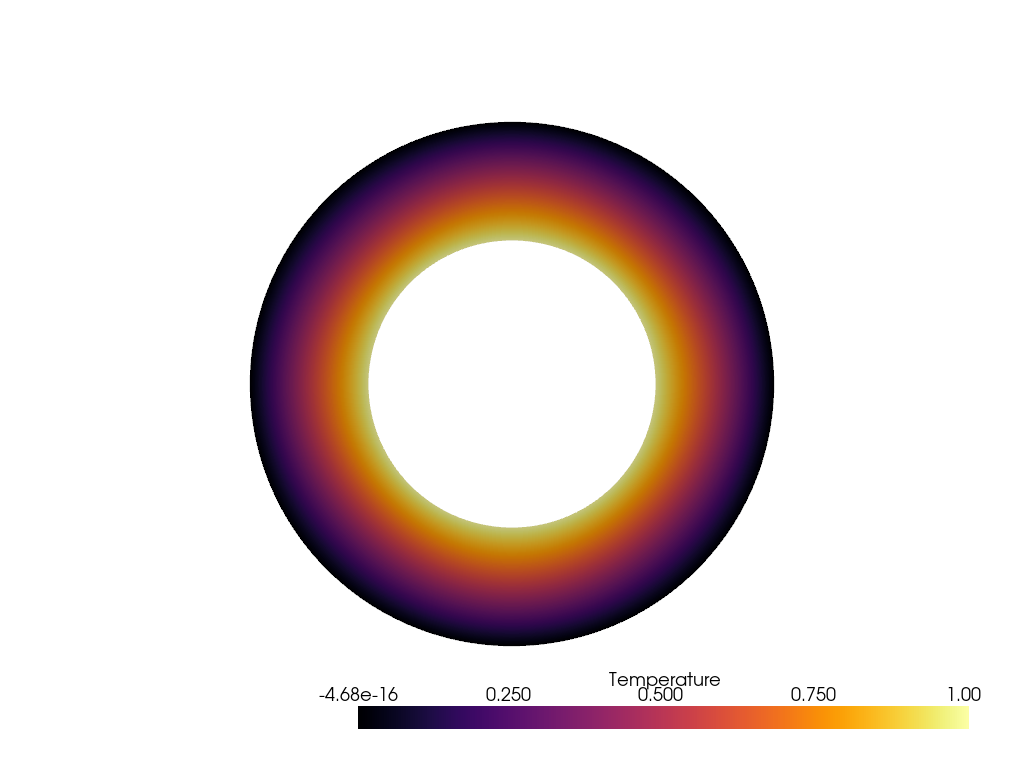

In [6]:
VTKFile("temp.pvd").write(T)
temp_data = pv.read("temp/temp_0.vtu")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(temp_data, cmap="inferno")
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

We now initialise the level-set field. Usually, one has to provide a mathematical
description of the interface location to the G-ADOPT API, which then determines the
signed-distance function using the `Shapely` library. Here, however, the interface is
a circle, and so the signed-distance function can be calculated in a straightforward
way using spatial coordinates. G-ADOPT then automatically derives the smooth
step-function profile typical of the conservative level-set method using a default
strategy to determine the profile's thickness.

In [7]:
interface_coord_r = rmin + (rmax - rmin) / 3  # Interface location
signed_distance = r - interface_coord_r  # Signed distance from the interface

epsilon = interface_thickness(K)
assign_level_set_values(psi, epsilon, signed_distance)  # Populate level-set field

Let us visualise the location of the material interface that we have just initialised.
To this end, we use Firedrake's built-in plotting functionality.

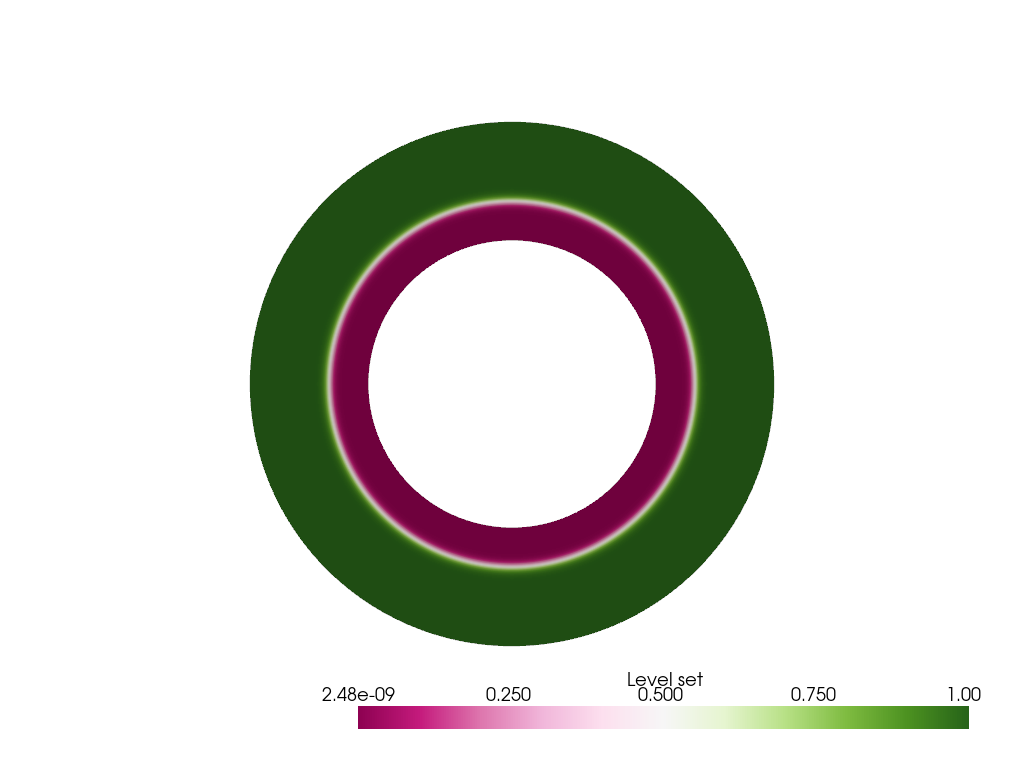

In [8]:
VTKFile("level_set.pvd").write(psi)
level_set_data = pv.read("level_set/level_set_0.vtu")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(level_set_data, cmap="PiYG")
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

We next define the material fields and instantiate the approximation. Here, the system
of equations is non-dimensional and includes compositional and thermal buoyancy terms
under the Boussinesq approximation. Thus, the system requires values for the thermal
and compositional Rayleigh numbers. We use the `material_field` function to define the
compositional Rayleigh number throughout the domain (including the mathematical
description of the material interface transition). Both non-dimensional numbers are
provided to our approximation. Moreover, the viscosity is material-dependent, and so
it must also be defined as a material field and provided to the approximation.

In [9]:
# For this tutorial, we use a buoyancy number of 2 and a viscosity contrast of 10. With
# such a combination, the deeper material is negatively buoyant and diffuses momentum
# efficiently, making it hard for any compositional upwelling to develop. This
# stratification has direct consequences on the mantle's thermal structure, as we will
# observe at the end of this tutorial.
Ra = 1e5  # Thermal Rayleigh number
# Compositional Rayleigh number defined based on each material value and location
RaB_buoyant, RaB_dense = 0.0, 2e5
RaB = material_field(psi, [RaB_dense, RaB_buoyant], interface="arithmetic")
# Viscosity defined based on each material value and location
mu = material_field(psi, [mu_dense := 10.0, mu_buoyant := 1.0], interface="geometric")

approximation = BoussinesqApproximation(Ra, RaB=RaB, mu=mu)

Let us now verify that the material fields have been correctly initialised. We plot
the compositional Rayleigh number across the domain.

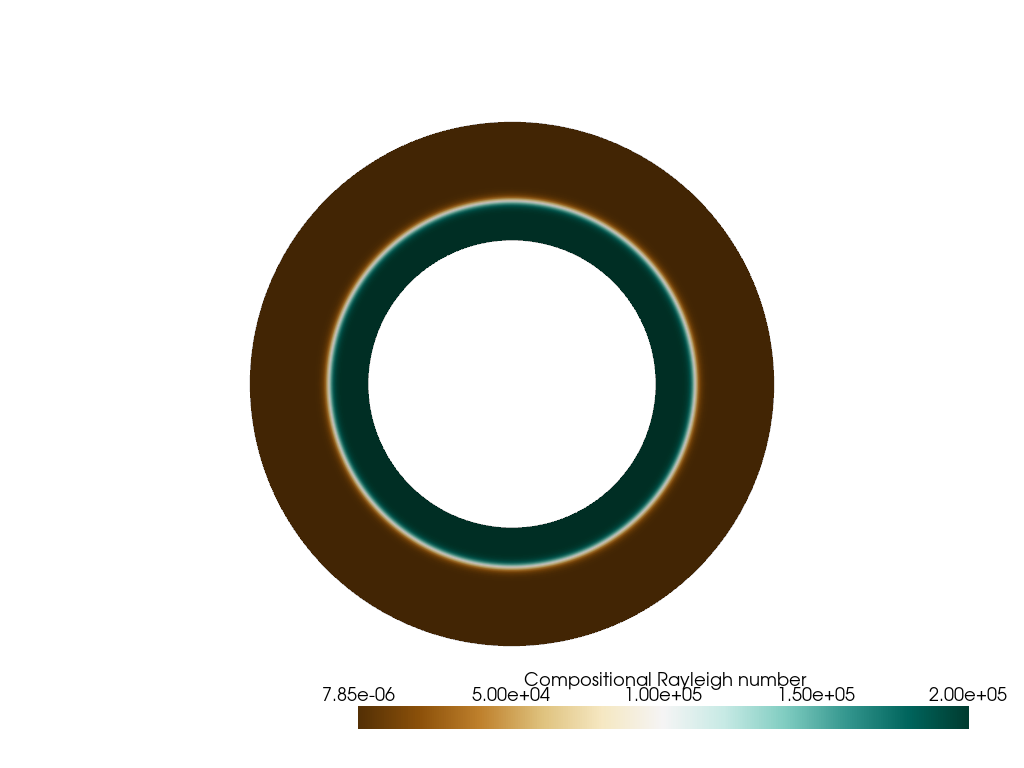

In [10]:
VTKFile("RaB.pvd").write(
    Function(psi, name="Compositional Rayleigh number").interpolate(RaB)
)
RaB_data = pv.read("RaB/RaB_0.vtu")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(RaB_data, cmap="BrBG")
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

As with the previous examples, we set up an instance of the `TimestepAdaptor` class
to control the time-step length (via a CFL criterion) whilst the simulation advances
in time. We specify the output frequency (in time units) at which fields will be
written for visualisation.

In [11]:
time_now = 0.0  # Initial time
output_frequency = 5e-4  # Frequency (based on simulation time) at which to output
t_adapt = TimestepAdaptor(
    time_step, u, V, target_cfl=0.6, maximum_timestep=output_frequency
)  # Current level-set advection requires a CFL condition that does not exceed 0.6.

The Stokes system defined here admits null modes, and we define a null-space object
including rigid-body (by default) and rotational modes to provide to the solver.

In [12]:
stokes_nullspace = create_stokes_nullspace(Z, rotational=True)

Boundary conditions are specified next. For temperature, they are set to $T = 0.0$ at
the surface ($r_{\text{max}}$) and $T = 1.0$ at the base ($r_{\text{min}}$). For
velocity, we implicitly specify free‐slip conditions on both boundaries by explicitly
setting the normal velocity component to 0.

In [13]:
temp_bcs = {boundary.bottom: {"T": 1.0}, boundary.top: {"T": 0.0}}
stokes_bcs = {boundary.bottom: {"un": 0.0}, boundary.top: {"un": 0.0}}

We can now set up the variational problem, for the energy, Stokes, and level-set
equations. The approximation, boundary conditions, and null space information
configured above are passed to the constructors as required. Critically, as the
viscosity is now varying in space, the Jacobian of the system is not constant anymore,
and the corresponding `StokesSolver` argument must not be specified.

In [14]:
# Instantiate a solver object for the energy conservation system.
energy_solver = EnergySolver(
    T, u, approximation, time_step, ImplicitMidpoint, bcs=temp_bcs
)
# Instantiate a solver object for the Stokes system and perform a solve to obtain
# initial pressure and velocity.
stokes_solver = StokesSolver(
    stokes,
    approximation,
    T,
    bcs=stokes_bcs,
    nullspace=stokes_nullspace,
    transpose_nullspace=stokes_nullspace,
)
stokes_solver.solve()

# Instantiate a solver object for level-set advection and reinitialisation. G-ADOPT
# defines default values for most arguments; here, we only provide those without one,
# namely the velocity field and time step (needed for advection) and the level-set
# interface thickness (needed for reinitialisation). No boundary conditions are
# required, as the numerical domain is closed.
adv_kwargs = {"u": u, "timestep": time_step}
reini_kwargs = {"epsilon": epsilon}
level_set_solver = LevelSetSolver(psi, adv_kwargs=adv_kwargs, reini_kwargs=reini_kwargs)

/__w/g-adopt/g-adopt/.venv/lib/python3.12/site-packages/gadopt/level_set_tools.py:537: UserWarning: No frequency strategy implemented for reinitialisation in non-rectangular/cuboidal domains; applying reinitialisation at every time step
  warn(


We now set up our output. To do so, we create the output file as a ParaView Data file
that uses the XML-based VTK file format. We also open a file for logging, instantiate
G-ADOPT geodynamical diagnostic utility, and define some parameters specific to this
problem.

In [15]:
output_file = VTKFile("output.pvd")
output_file.write(*stokes.subfunctions, T, psi, time=time_now)

plog = ParameterLog("params.log", mesh)
plog.log_str("step time dt u_rms nu_base nu_top energy avg_t T_min T_max entrainment")

gd = GeodynamicalDiagnostics(stokes, T, boundary.bottom, boundary.top, quad_degree=6)

# Geometric scalings used for the Nusselt numbers
r_ratio = rmin / rmax
top_scaling = ln(r_ratio) / (r_ratio - 1.0)
bot_scaling = r_ratio * ln(r_ratio) / (r_ratio - 1.0)

# Area of tracked material in the domain
material_area = pi * (interface_coord_r**2 - rmin**2)
entrainment_height = interface_coord_r  # Height above which entrainment is calculated

Finally, we initiate the time loop, which runs until the simulation end time is
attained.

In [16]:
step = 0  # A counter to keep track of looping
output_counter = 1  # A counter to keep track of outputting
steady_state_tolerance = 1e-4  # Threshold identifying a steady-state solution
while True:
    # Update timestep
    t_adapt.update_timestep()

    # Advect and reinitialise level set
    level_set_solver.solve()
    # Solve energy system
    energy_solver.solve()
    # Solve Stokes sytem
    stokes_solver.solve()

    # Increment iteration count and time
    step += 1
    time_now += float(time_step)

    # Compute diagnostics:
    nusselt_number_top = gd.Nu_top() * top_scaling
    nusselt_number_base = gd.Nu_bottom() * bot_scaling
    energy_conservation = abs(abs(nusselt_number_top) - abs(nusselt_number_base))

    # Calculate proportion of material entrained above a given height
    buoy_entr = material_entrainment(
        psi,
        material_size=material_area,
        entrainment_height=entrainment_height,
        side=0,
        direction="above",
        skip_material_size_check=True,
    )

    # Log diagnostics:
    plog.log_str(
        f"{step} {time_now} {float(time_step)} {gd.u_rms()} {nusselt_number_base} "
        f"{nusselt_number_top} {energy_conservation} {gd.T_avg()} {gd.T_min()} "
        f"{gd.T_max()} {buoy_entr}"
    )

    # Write output
    if time_now >= output_counter * output_frequency:
        output_file.write(*stokes.subfunctions, T, psi, time=time_now)
        output_counter += 1

    # Check if simulation has reached a steady state
    if time_now > 0.001 and norm(T - energy_solver.T_old) < steady_state_tolerance:
        plog.close()  # Close logging file

        # Checkpoint solution fields to disk
        with CheckpointFile("final_state.h5", "w") as final_checkpoint:
            final_checkpoint.save_mesh(mesh)
            final_checkpoint.save_function(T, name="Temperature")
            final_checkpoint.save_function(stokes, name="Stokes")
            final_checkpoint.save_function(psi, name="Level set")

        log("Reached end of simulation -- exiting time-step loop")
        break

Reached end of simulation -- exiting time-step loop


Let us finally examine the location of the material interface and the temperature
field at the end of the simulation.

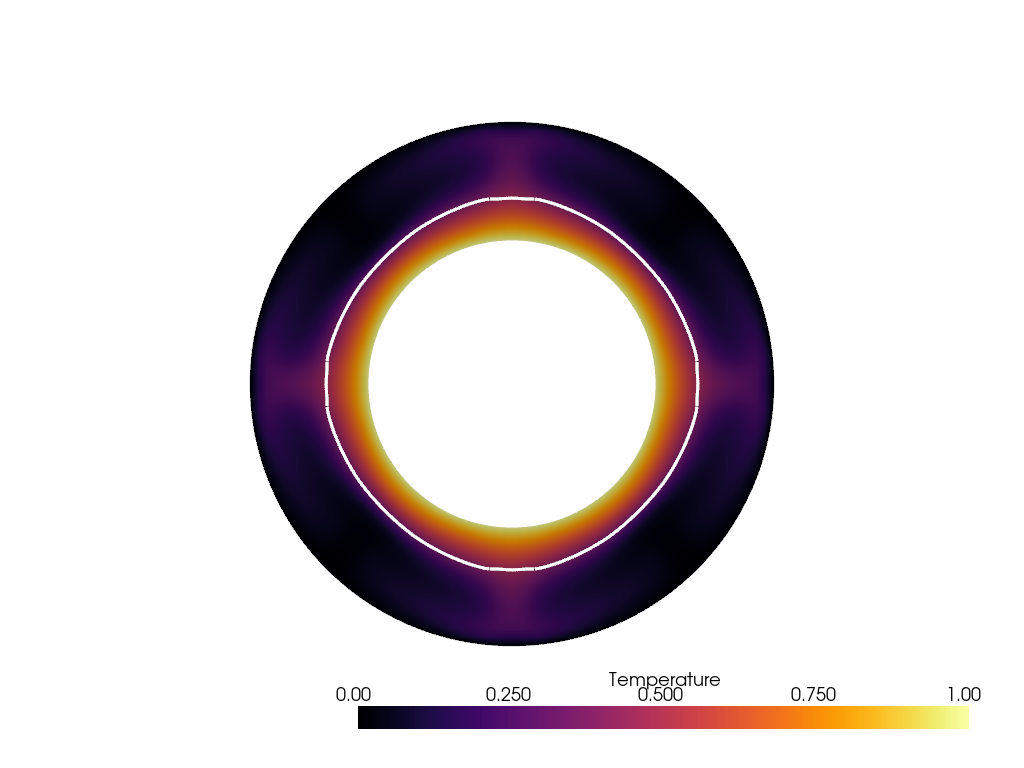

In [17]:
reader = pv.get_reader("output.pvd")
reader.set_active_time_point(len(reader.time_values) - 1)
data = reader.read()[0]
data.set_active_scalars("Temperature")
contour = data.contour(isosurfaces=[0.5], scalars="Level set")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(data, cmap="inferno")
plotter.add_mesh(contour, color="white", line_width=3)
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

It is clear from this view that the dense and viscous material at the base of the
domain had a critical impact on the system's evolution. By remaining close to the
inner hot boundary, it isolated it and limited the scope of thermal upwellings, which
led to significant cooling from the top boundary.